# Previsão com Redes Neurais Recorrentes


In [1]:
import pandas as pd
from pandas import Grouper, DataFrame

from typing import Tuple, List, Callable, Dict

import numpy as np
import os
from datetime import datetime
import random
import time

from matplotlib import pyplot as plt
import seaborn as sns

import inspect
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

import pickle

import tensorflow as tf

from math import ceil

## Constantes

In [2]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

TEST_SPLIT_SIZE = 8
VAL_SPLIT_SIZE = 15
WINDOW_SIZE = 24
MEAN_SQUARED_METRIC = "mean_squeared"
MEAN_ABSOLUTE_METRIC = "mean_absolute"
R2_METRIC = "r2"

MODEL_PATH = 'MODEL'
SCALER_FEATURE_FILE_NAME = os.path.join(MODEL_PATH, 'scaler-multivariate-feature.pkl')
SCALER_LABEL_FILE_NAME = os.path.join(MODEL_PATH, 'scaler-multivariate-label.pkl')

BATCH_SIZE = 100


## Funções

In [3]:
# returns normalize array, feature scaler, label scaler
def normalize_data(full_dataset: np.ndarray,
                   label_column: int,
                   val_percentual_size: int,
                   test_percentual_size: int) -> Tuple[np.ndarray, MinMaxScaler, MinMaxScaler]:
    
    train_size: int = 100 - (val_percentual_size + test_percentual_size)
    limit_index = round(len(full_dataset) * (train_size/100))
    feature_ds = full_dataset[:limit_index, :]
    label_ds = full_dataset[:limit_index, label_column].reshape(-1,1)
    
    scaler_feature = MinMaxScaler()
    scaler_label = MinMaxScaler()
    
    scaler_feature.fit(feature_ds)
    scaler_label.fit(label_ds)
    
    scaled_ds: np.ndarray = scaler_feature.transform(full_dataset)
    
    return (scaled_ds, scaler_feature, scaler_label)
    

In [4]:
# Returns X_train, y_train, X_valid, y_valid, X_test, y_test
# A normalzação precisou ser feita no split porque a janela transformava o array em 3d,  o MinMaxScaler não aceita array 3d
def split_train_validation_test_window_dataset(full_dataset: np.ndarray, 
                                               label_column: int,
                                               val_percentual_size: int, 
                                               test_percentual_size: int, 
                                               window_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    #posições
    dataset_size: int = full_dataset.shape[0]
    cut_pos_test: int = round(dataset_size - (dataset_size * (test_percentual_size/100)))
    cut_pos_val: int = round(cut_pos_test - (dataset_size * (val_percentual_size/100)))
    
    #tamanho splits
    test_dataset_size: int = dataset_size - cut_pos_test
    val_dataset_size: int = dataset_size - cut_pos_val - test_dataset_size
    
    y_train: np.ndarray = full_dataset[window_size : cut_pos_val, label_column]
    y_val: np.ndarray = full_dataset[cut_pos_val : cut_pos_test, label_column]
    y_test: np.ndarray = full_dataset[cut_pos_test:, label_column]
    
    train_dataset_list = [full_dataset[ind : ind + window_size, :] for ind in range (cut_pos_val - window_size)]
    X_train = np.array(train_dataset_list)
    
    val_dataset_list = [full_dataset[cut_pos_val + ind - window_size :cut_pos_val + ind, :] for ind in range (val_dataset_size)]
    X_valid = np.array(val_dataset_list)
    
    test_dataset_list = [full_dataset[cut_pos_test + ind - window_size :cut_pos_test + ind, :] for ind in range (test_dataset_size)]
    X_test = np.array(test_dataset_list)
    
    return (X_train, y_train, X_valid, y_val, X_test, y_test)

## Carrega Datasets

In [56]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')
df_oec_mpme_multivariate = df_oec_mpme[['ano','mes', 'ano_mes', 'desembolso', 'vendas', 'aprovacao', 'ind_atv_econ', 'dif_custo_bndes_mercado']]

desembolso_multivariate = df_oec_mpme_multivariate[['desembolso', 'vendas', 'aprovacao', 'ind_atv_econ', 'dif_custo_bndes_mercado']].to_numpy()

desembolso_time = df_oec_mpme_multivariate[["ano_mes"]].to_numpy().squeeze()

In [57]:
df_oec_mpme_multivariate.tail(30)

,ano,mes,ano_mes,desembolso,vendas,aprovacao,ind_atv_econ,dif_custo_bndes_mercado
data_base,,,,,,,,
2019-06-01,2019,6,2019-06,502.100833,9775.0,457.951825,138.80000,0.803933
2019-07-01,2019,7,2019-07,353.451083,11396.0,389.639673,138.31000,1.163795
2019-08-01,2019,8,2019-08,345.369966,12289.0,353.177929,138.09000,0.855072
2019-09-01,2019,9,2019-09,295.968106,11624.0,298.000681,138.79000,0.683761
2019-10-01,2019,10,2019-10,308.043389,12198.0,338.071746,138.98000,1.071768
2019-11-01,2019,11,2019-11,204.996100,11392.0,246.977942,138.80000,0.972380
2019-12-01,2019,12,2019-12,236.630800,10762.0,231.089803,138.30000,0.658464
2020-01-01,2020,1,2020-01,191.533696,9341.0,197.294109,138.58000,0.782325
2020-02-01,2020,2,2020-02,132.588240,8348.0,197.711762,139.52000,0.638373


In [58]:

(desembolso_multivariate, scaler_feature, scaler_label) = normalize_data(full_dataset=desembolso_multivariate, 
                                                                         label_column=0, 
                                                                         val_percentual_size=VAL_SPLIT_SIZE, 
                                                                         test_percentual_size=TEST_SPLIT_SIZE)

pickle.dump(scaler_feature, open(SCALER_FEATURE_FILE_NAME, 'wb'))
pickle.dump(scaler_label, open(SCALER_FEATURE_FILE_NAME, 'wb'))

In [59]:
(X_train, y_train, X_valid, y_valid, X_test, y_test) = split_train_validation_test_window_dataset(full_dataset=desembolso_multivariate, 
                                                                                                  label_column=0,
                                                                                                  val_percentual_size=VAL_SPLIT_SIZE, 
                                                                                                  test_percentual_size=TEST_SPLIT_SIZE, 
                                                                                                  window_size=WINDOW_SIZE)

In [61]:
n_samples = X_train.shape[0] # samples
n_timesteps = X_train.shape[1] # window_size
n_features =  desembolso_multivariate.shape[1] #multivariate

#X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features)
#X_valid_rs = X_valid.reshape(X_valid.shape[0], n_timesteps, n_features)

In [62]:
print(n_samples, n_timesteps, n_features)

88 24 5


---
### Multivariate LSTM

In [63]:
# RNN recebe input_shape no seguinte formato
# (N,T,D), where N is the number of samples, T is length of time sequence and D is the number of features

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(n_timesteps,n_features)),
    #tf.keras.layers.LSTM(100, input_shape=(n_timesteps,n_features), return_sequences=True),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=50,return_sequences=False)),
    #tf.keras.layers.LSTM(50, return_sequences=False),
    #tf.keras.layers.Dense(20, activation='softmax'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])

lstm_model.compile(optimizer='adam', loss='mse')


In [64]:
model_multivariate_path = os.path.join(MODEL_PATH, 'model-lstm-desembolso-multivariate.h5')

history = lstm_model.fit(x=X_train,
                         y=y_train,
                         validation_data=(X_valid, y_valid),
                         epochs=150,
                         shuffle=False,
                         batch_size=BATCH_SIZE,
                         callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
                                     tf.keras.callbacks.ModelCheckpoint(model_multivariate_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                        )

Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 0.1037 - val_loss: 0.0517
Epoch 2/150
1/1 [==============================] - 0s 87ms/step - loss: 0.0332 - val_loss: 0.1126
Epoch 3/150
1/1 [==============================] - 0s 82ms/step - loss: 0.0606 - val_loss: 0.0866
Epoch 4/150
1/1 [==============================] - 0s 108ms/step - loss: 0.0521 - val_loss: 0.0428
Epoch 5/150
1/1 [==============================] - 0s 108ms/step - loss: 0.0311 - val_loss: 0.0145
Epoch 6/150
1/1 [==============================] - 0s 114ms/step - loss: 0.0225 - val_loss: 0.0036
Epoch 7/150
1/1 [==============================] - 0s 119ms/step - loss: 0.0258 - val_loss: 0.0018
Epoch 8/150
1/1 [==============================] - 0s 96ms/step - loss: 0.0311 - val_loss: 0.0018
Epoch 9/150
1/1 [==============================] - 0s 97ms/step - loss: 0.0317 - val_loss: 0.0020
Epoch 10/150
1/1 [==============================] - 0s 97ms/step - loss: 0.0276 - val_loss: 0.0036
Epoch 11/150
1/1 

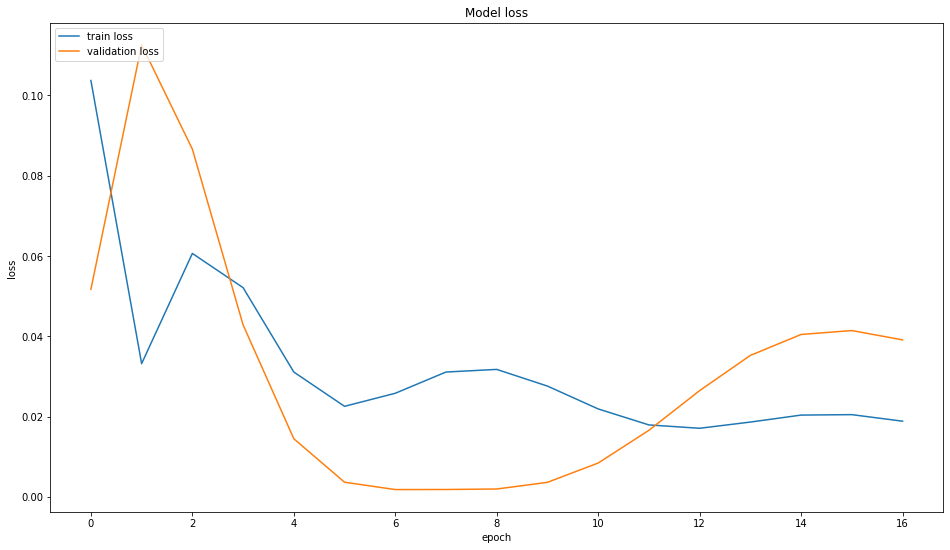

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [66]:
model_multivariate = tf.keras.models.load_model(model_multivariate_path)

In [67]:
y_predict = model_multivariate.predict(X_test)
y_predict = scaler_label.inverse_transform(y_predict).squeeze()
y_true = scaler_label.inverse_transform(y_test.reshape(-1,1)).squeeze()
y_train_graph = scaler_label.inverse_transform(y_train.reshape(-1,1)).squeeze()
y_valid_graph = scaler_label.inverse_transform(y_valid.reshape(-1,1)).squeeze()

In [69]:
print(y_predict)

[307.26657 326.02982 338.34174 352.92123 374.97348 397.07492 424.84137
 450.85812 472.548   495.70953 516.5056  532.13153]


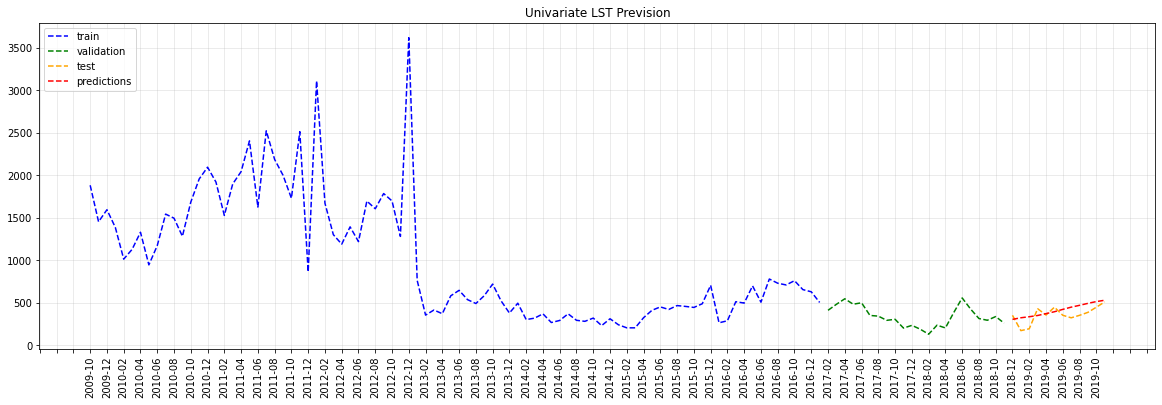

In [70]:
len_train = len(y_train)
len_with_valid = len(y_train) + len(y_valid)
len_with_test = len(y_train) + len(y_valid) + len(y_test)

plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len_train], y_train_graph, 'b--', label="train")
plt.plot(desembolso_time[len_train:len_with_valid], y_valid_graph, color='green', linestyle="--", label="validation")
plt.plot(desembolso_time[len_with_valid:len_with_test], y_true, color='orange', linestyle='--', label="test")
plt.plot(desembolso_time[len_with_valid:len_with_test], y_predict, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Univariate LST Prevision")
plt.grid(alpha=0.3);

In [71]:
multivariate_lstm_mse = mean_squared_error(y_true, y_predict, squared=True)
multivariate_lstm_mae = mean_absolute_error(y_true, y_predict)
multivariate_lstm_r2 = r2_score(y_true, y_predict)
print(f'Mean Squared Error: {multivariate_lstm_mse} ')
print(f'Mean Absolute Error: {multivariate_lstm_mae}')
print(f'R2 Score: {multivariate_lstm_r2}')

Mean Squared Error: 8739.001022122311 
Mean Absolute Error: 82.79475934619138
R2 Score: 0.02729441820652534
